In [1]:
import pandas as pd
import csv
from pandas import DataFrame, Series
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from sqlalchemy import create_engine
from sqlalchemy.sql import text

In [2]:
conn = create_engine('postgresql://akokai@localhost/chmdata')
cpds_cols = ['dtxsid', 'cid', 'inchikey', 'inchi', 'molecule']

# Example searches

## Search for dibenzodioxins

Using the canonical SMILES for dibenzodioxin as a search query:

In [13]:
cmd = text('''select cid, inchi, molecule from cpds where molecule @> 'C1=CC=C2C(=C1)OC3=CC=CC=C3O2';''')
dioxins = DataFrame(conn.execute(cmd).fetchall(), columns=['cid', 'inchi', 'molecule'])
dioxins

,cid,inchi,molecule
0,9216,InChI=1S/C12H8O2/c1-2-6-10-9(5-1)13-11-7-3-4-8...,c1ccc2c(c1)Oc1ccccc1O2
1,36613,InChI=1S/C12H6Cl2O2/c13-7-1-3-9-11(5-7)16-10-4...,Clc1ccc2c(c1)Oc1ccc(Cl)cc1O2
2,29575,InChI=1S/C12H2Cl6O2/c13-3-1-5-11(9(17)7(3)15)2...,Clc1cc2c(c(Cl)c1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2
3,15625,InChI=1S/C12H4Cl4O2/c13-5-1-9-10(2-6(5)14)18-1...,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2
4,42540,InChI=1S/C12H2Cl6O2/c13-3-1-5-11(9(17)7(3)15)2...,Clc1cc2c(c(Cl)c1Cl)Oc1cc(Cl)c(Cl)c(Cl)c1O2
5,18636,InChI=1S/C12Cl8O2/c13-1-2(14)6(18)10-9(5(1)17)...,Clc1c(Cl)c(Cl)c2c(c1Cl)Oc1c(Cl)c(Cl)c(Cl)c(Cl)...
6,38251,InChI=1S/C12H2Cl6O2/c13-3-1-5-6(2-4(3)14)20-12...,Clc1cc2c(cc1Cl)Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1O2
7,38439,InChI=1S/C12H3Cl5O2/c13-4-1-7-8(2-5(4)14)19-12...,Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2
8,37270,InChI=1S/C12HCl7O2/c13-2-1-3-10(7(17)4(2)14)21...,Clc1cc2c(c(Cl)c1Cl)Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1O2
9,86291,InChI=1S/C12H4Br4O2/c13-5-1-7(15)11-9(3-5)17-1...,Brc1cc(Br)c2c(c1)Oc1cc(Br)cc(Br)c1O2


### Draw the first 10 dioxins...

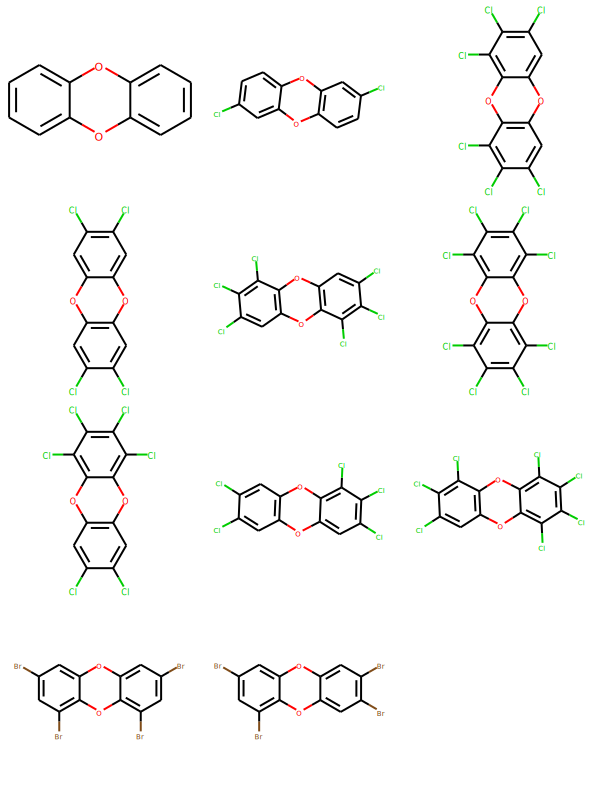

In [14]:
dioxins['mol'] = dioxins.inchi.apply(Chem.MolFromInchi)
Draw.MolsToGridImage(dioxins.loc[:10, 'mol'])

## Search for phthalates

Again using a SMILES substructure query.

In [9]:
cmd = text('''select cid, inchi, molecule from cpds where molecule @> 'COC(=O)c1[cH][cH][cH][cH]c1C(=O)OC';''')
phths = DataFrame(conn.execute(cmd).fetchall(), columns=['cid', 'inchi', 'molecule'])
phths

,cid,inchi,molecule
0,2347,InChI=1S/C19H20O4/c1-2-3-13-22-18(20)16-11-7-8...,CCCCOC(=O)c1ccccc1C(=O)OCc1ccccc1
1,8560,InChI=1S/C14H14O4/c1-3-9-17-13(15)11-7-5-6-8-1...,C=CCOC(=O)c1ccccc1C(=O)OCC=C
2,8343,InChI=1S/C24H38O4/c1-5-9-13-19(7-3)17-27-23(25...,CCCCC(CC)COC(=O)c1ccccc1C(=O)OCC(CC)CCCC
3,5171383,InChI=1S/C28H34O10/c29-15-5-7-17-35-25(31)21-1...,O=C(OCCCCO)c1ccccc1C(=O)OCCCCOC(=O)c1ccccc1C(=...
4,6778,InChI=1S/C20H14O4/c21-19(23-15-9-3-1-4-10-15)1...,O=C(Oc1ccccc1)c1ccccc1C(=O)Oc1ccccc1
5,6781,InChI=1S/C12H14O4/c1-3-15-11(13)9-7-5-6-8-10(9...,CCOC(=O)c1ccccc1C(=O)OCC
6,3026,InChI=1S/C16H22O4/c1-3-5-11-19-15(17)13-9-7-8-...,CCCCOC(=O)c1ccccc1C(=O)OCCCC
7,8346,InChI=1S/C24H38O4/c1-3-5-7-9-11-15-19-27-23(25...,CCCCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCCC
8,8554,InChI=1S/C10H10O4/c1-13-9(11)7-5-3-4-6-8(7)10(...,COC(=O)c1ccccc1C(=O)OC
9,6782,InChI=1S/C16H22O4/c1-11(2)9-19-15(17)13-7-5-6-...,CC(C)COC(=O)c1ccccc1C(=O)OCC(C)C


Draw the first 10 phthalates...

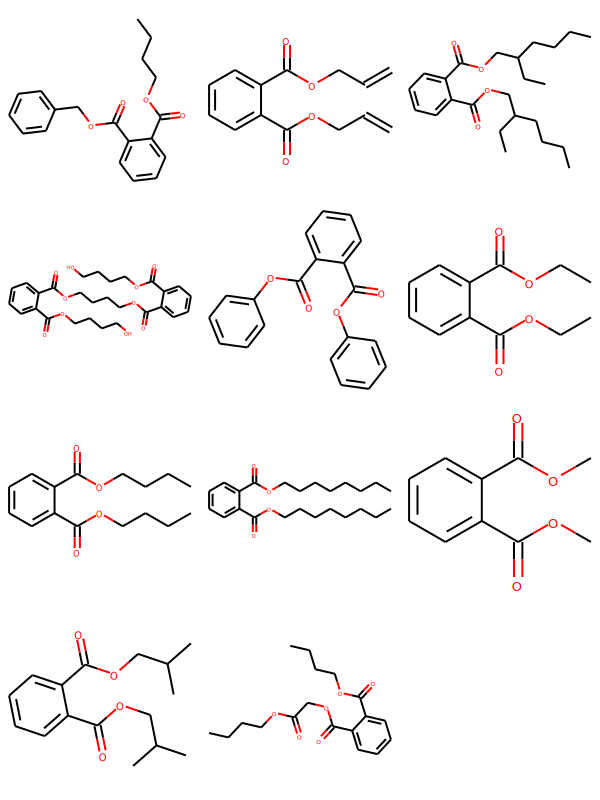

In [10]:
phths['mol'] = phths.inchi.apply(Chem.MolFromInchi)
Draw.MolsToGridImage(phths.loc[:10, 'mol'])